## Making training data

This notebook describes the workflow for generating training data
from templates

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import platform

from pathlib import Path
from os.path import expanduser
from os import path, getcwd
import logging

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn_evaluation import plot as sk_plot

import yass
from yass import read_config, preprocess, detect
from yass import util
from yass.augment import make
from yass.neuralnetwork import NeuralNetDetector, NeuralNetTriage, AutoEncoder 
from yass.explore import RecordingExplorer, SpikeTrainExplorer
from yass.augment.noise import noise_cov
from yass.templates import TemplatesProcessor
from yass.augment.util import amplitudes
from yass.geometry import make_channel_index

import numpy as np
from scipy.io import loadmat

from dstools import plot
from dstools.reproducibility import make_filename
from dstools.reproducibility.util import get_version, git_hash_in_path
from dstools.util import save

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from sklearn.model_selection import train_test_split

# logging.basicConfig(level=logging.DEBUG)

Using TensorFlow backend.


In [3]:
here = getcwd()
here_version = git_hash_in_path(here)

In [4]:
# for reference
print('YASS version is: {}'.format(util.get_version()))
print('nbs version is: {}'.format(here_version))

YASS version is: 9220361 fixes make spikes function
nbs version is: a786da4 Merge branch 'master' of https://github.com/edublancas/yass-private


In [5]:
path_to_data = path.expanduser('~/data')
path_to_ground_truth = path.join(path_to_data,
                                 'retinal/groundtruth_ej49_data1_set1.mat')
path_to_experiment = path.join(path_to_data, 'retinal/sample_output')
path_to_standarized = path.join(path_to_experiment,
                                'preprocess', 'standarized.bin')
path_to_geom = path.join(path_to_data, 'retinal/ej49_geometry1.txt')
path_to_here = path.expanduser('~/dev/private-yass/nnet')

In [6]:
yass.set_config("../../config/gcloud/49/default.yaml", 'tmp')
CONFIG = read_config()

## Loading templates

In [7]:
raw_templates = np.load(Path(path_to_data, 'cat/templates-jul27-only-good.npy'))
n_templates, waveform_length, _ = raw_templates.shape
print(raw_templates.shape)

(240, 61, 49)


In [8]:
# crop spatially
processor = TemplatesProcessor(raw_templates)
templates = (processor
            .crop_spatially(CONFIG.neigh_channels, CONFIG.geom)
            .values)
templates.shape

(240, 61, 7)

In [9]:
np.max(np.abs(templates))

60.34858703613281

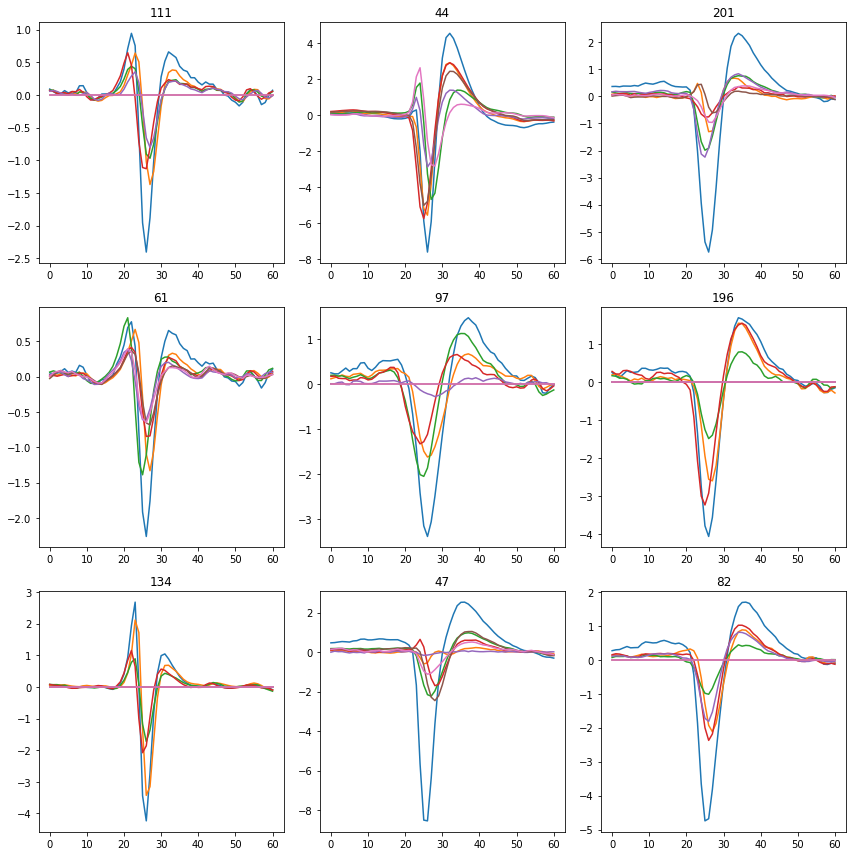

In [10]:
plot.grid_from_array(templates, axis=0, auto_figsize=4,
                     max_cols=3, elements=9)

## Generating training data

In [11]:
templates.shape

(240, 61, 7)

In [12]:
ch_idx = make_channel_index(CONFIG.neigh_channels, CONFIG.geom)
selected_channels = ch_idx[0]
selected_channels

array([0, 1, 2, 3, 4, 5, 6], dtype=int32)

In [13]:
from yass.batch import RecordingsReader

rec = RecordingsReader(path_to_standarized, loader='array').data[:, selected_channels]

(spatial_sig,
 temporal_sig) = noise_cov(rec, templates.shape[1], templates.shape[1])

In [51]:
min_amplitude = 4
max_amplitude = 60

n_clean_per_template = 20

n_positive_total = n_templates *  n_clean_per_template

n_collided_per_spike = 0

In [52]:
n_positive_total

4800

In [61]:
from yass.augment.util import make_from_templates, add_noise

x = make_from_templates(templates, min_amplitude=10, max_amplitude=50,
                    n_per_template=10)

x = add_noise(x, spatial_sig, temporal_sig)

from yass.templates.util import amplitudes
amps = amplitudes(x) 
amps.min(), amps.max()

(5.6463075205306135, 52.52320018482792)

In [186]:
from yass.augment import util
import yass.array as yarr

def training_data_detect(templates,
                         minimum_amplitude,
                         maximum_amplitude,
                         n_clean_per_template,
                         n_collided_per_spike,
                         n_temporally_misaligned_per_spike,
                         n_noise,
                         spatial_SIG,
                         temporal_SIG,
                         from_templates_kwargs={},
                         collided_kwargs={},
                         temporally_misaligned_kwargs={}):
    """Make training data for detector network


    Notes
    -----
    Recordings are passed through the detector network which identifies
    spikes (clean and collided), it rejects noise and misaligned spikes
    (temporally and spatially)
    """

    # make spikes from templates
    x_templates = util.make_from_templates(templates, minimum_amplitude,
                                           maximum_amplitude,
                                           n_clean_per_template,
                                           **from_templates_kwargs)
    
    amps = amplitudes(x_templates) 
    print(amps.min(), amps.max())

    # now spatially misalign (shuffle channels)
    fn = util.make_spatially_misaligned
    x_spatially = fn(x_templates, n_per_spike=1,
                     force_first_channel_shuffle=False)

    x_collision = util.make_collided(x_templates, x_spatially,
                                     n_collided_per_spike,
                                     **collided_kwargs)

    # create temporally misaligned spikes
    fn = util.make_temporally_misaligned
    x_misalign = fn(x_spatially, n_temporally_misaligned_per_spike,
                    **temporally_misaligned_kwargs)

    x_noise = util.make_noise(n_noise, spatial_SIG, temporal_SIG)

    # make labels
    ones = np.ones(len(x_templates) + len(x_collision))
    zeros = np.zeros(len(x_misalign) + len(x_noise))

    x_templates_noisy = util.add_noise(x_templates, spatial_SIG, temporal_SIG)
    
    amps = amplitudes(x_templates_noisy) 
    print(amps.min(), amps.max())

    x_collision_noisy = add_noise(x_collision, spatial_SIG, temporal_SIG)
    x_misaligned_noisy = add_noise(x_misalign, spatial_SIG, temporal_SIG)

    X = yarr.concatenate((x_templates_noisy, x_collision_noisy,
                          x_misaligned_noisy, x_noise))

    y = np.concatenate((ones, zeros))

    return X, y, x_templates, x_templates_noisy

def add_noise(x, spatial_SIG, temporal_SIG):
    """Returns a noisy version of x
    """
    noise = util.make_noise(x.shape[0], spatial_SIG, temporal_SIG)
    return x + noise


In [187]:
(X, y, x, x_n) = training_data_detect(templates=templates,
                                   minimum_amplitude=min_amplitude,
                                   maximum_amplitude=max_amplitude,
                                   n_clean_per_template=n_clean_per_template,
                                   n_collided_per_spike=n_collided_per_spike,
                                   n_temporally_misaligned_per_spike=0.5,
                                   n_noise=int(n_positive_total * 10),
                                   spatial_SIG=spatial_sig,
                                   temporal_SIG=temporal_sig)

4.0 60.0
2.9051717869140736 62.58400419606128


In [188]:
X.shape, y.shape

((55200, 61, 7), (55200,))

In [189]:
from yass.templates.util import amplitudes
amps = amplitudes(x_n) 
amps.min(), amps.max()

(2.9051717869140736, 62.58400419606128)

In [196]:
amps.shape

(4800,)

In [194]:
(amps <= 6).sum()

265

In [190]:
s = np.argsort(amps)
s[:10]

array([1060, 2580, 4580, 2400,  540,  460,  940, 2220, 2000, 4360])

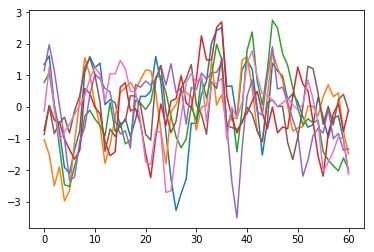

In [191]:
plt.plot(x_n[1060])

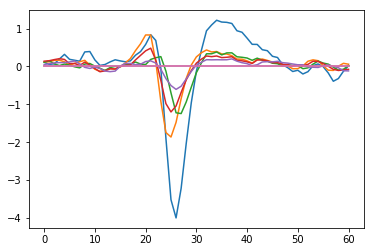

In [192]:
plt.plot(x[4540])

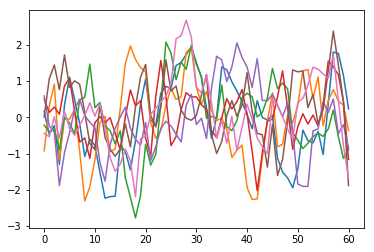

In [183]:
bad_noise = x_n[4540] - x[4540]
plt.plot(bad_noise)

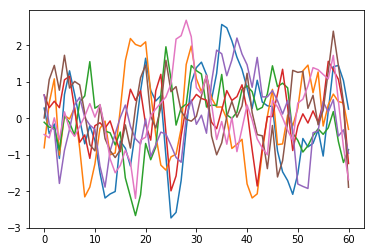

In [185]:
plt.plot(x[4540] + bad_noise)

In [165]:
noise = util.make_noise(1, spatial_sig, temporal_sig)[0]

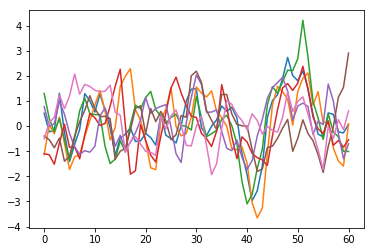

In [166]:
plt.plot(noise)

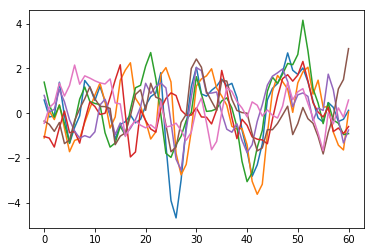

In [167]:
plt.plot(x[960] + noise)

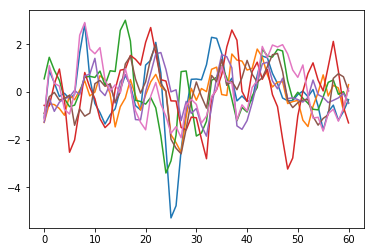

In [161]:
plt.plot(util.add_noise(x[[960]], spatial_sig, temporal_sig)[0])

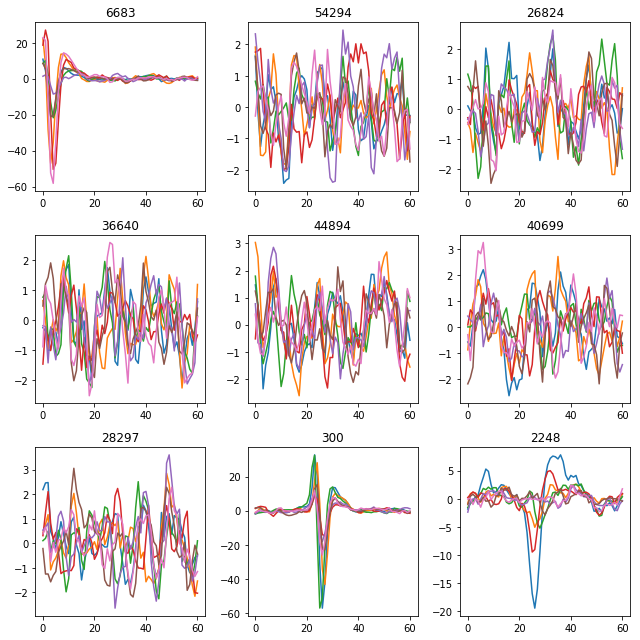

In [208]:
a = amplitudes(X)
sub = ~np.logical_and(y == 1, a <= 6)
d = X[sub]

plot.grid_from_array(d, axis=0,
                     elements=9, auto_figsize=3,
                     sharey=False)

X = X[sub]
y = y[sub]

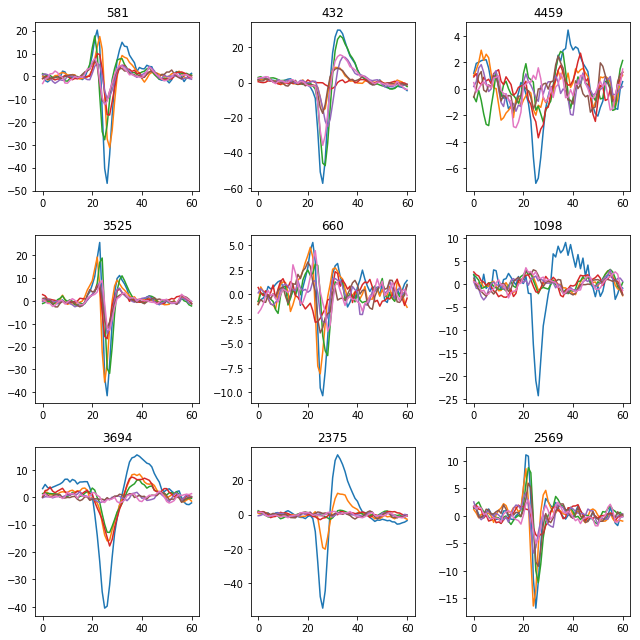

In [209]:
plot.grid_from_array(X[y == 1], axis=0,
                     elements=9, auto_figsize=3,
                     sharey=False)

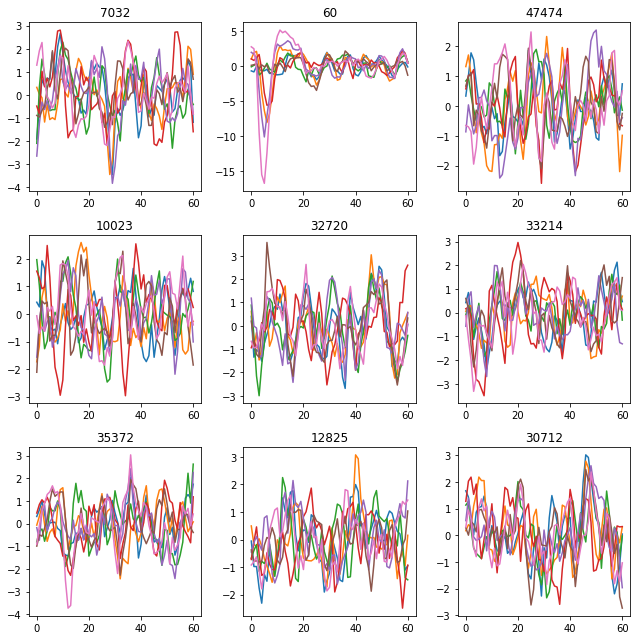

In [210]:
plot.grid_from_array(X[y == 0], axis=0,
                     elements=9, auto_figsize=3,
                     sharey=False)

In [211]:
path_to_output = Path(path_to_data, 'detect', 'training-set.npz')
np.savez(path_to_output, X=X, y=y)